# Gridded Datasets

/usr/lib/python3.6/site-packages/holoviews-1.9.2-py3.6.egg/holoviews/plotting/mpl/__init__.py:30: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()



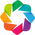

In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
hv.extension('bokeh', 'matplotlib')

In the [previous guide](3-Tabular_Datasets.ipynb) we discovered how to work with tabular datasets. Although tabular datasets are extremely common, many other datasets are best represented by regularly sampled n-dimensional arrays (such as images, volumetric data, or higher dimensional parameter spaces). On a 2D screen and using traditional plotting libraries, it is often difficult to visualize such parameter spaces quickly and succinctly, but HoloViews lets you quickly slice and dice such a dataset to explore the data and answer questions about it easily.

## Gridded

Gridded datasets usually represent observations of some continuous variable across multiple dimensions---a monochrome image representing luminance values across a 2D surface, volumetric 3D data, an RGB image sequence over time, or any other multi-dimensional parameter space. This type of data is particularly common in research areas that make use of spatial imaging or modeling, such as climatology, biology, and astronomy but can also be used to represent any arbitrary data that vary over multiple dimensions.

In HoloViews terminology the dimensions the data vary over are the so called key dimensions (**kdims**), which define the coordinates of the underlying array. The actual value arrays are described by the value dimensions (**vdims**). Libraries like ``xarray`` or ``iris`` allow you to store the coordinates with the array, but here we will declare the coordinate arrays ourselves so we can get a better understanding of how the gridded data interfaces work. We will therefore start by loading a very simple 3D array:

In [2]:
data = np.load('../assets/twophoton.npz')
calcium_array = data['Calcium']
calcium_array.shape

(62, 111, 50)

This particular NumPy dataset contains data from a 2-photon calcium imaging experiment, which provides an indirect measure of neural activity encoded via changes in fluorescent light intensity. The 3D array represents the activity of a 2D imaging plane over time, forming a sequence of images with a shape of (62, 111) over 50 time steps. Just as we did in the [Tabular Dataset](../4-Tabular_Datasets.ipynb) getting-started guide we start by wrapping our data in a HoloViews ``Dataset``. However, for HoloViews to understand the raw NumPy array we need to pass coordinates for each of the dimensions (or axes) of the data. For simplicity, here we will simply use integer coordinates for the ``'Time'``, ``'x'`` and ``'y'`` dimensions:

In [3]:
ds = hv.Dataset((np.arange(50), np.arange(111), np.arange(62), calcium_array),
                ['Time', 'x', 'y'], 'Fluorescence')
ds

:Dataset   [Time,x,y]   (Fluorescence)

As we should be used to by now the ``Dataset`` repr shows us the dimensions of the data. If we inspect the ``.data`` attribute we can see that by default HoloViews will store this data as a simple dictionary of our key dimension coordinates and value dimension arrays:

In [4]:
type(ds.data), list(ds.data.keys())

(dict, ['Time', 'x', 'y', 'Fluorescence'])

### Other datatypes

Instead of defining the coordinates manually, we recommend using [xarray](http://xarray.pydata.org/en/stable/), which will flexibly work with labeled n-dimensional arrays. We can even make a clone of our dataset and set the datatype to xarray to convert to an ``xarray.Dataset``, which is the recommended format for gridded data in HoloViews:

In [5]:
ds.clone(datatype=['xarray']).data

<xarray.Dataset>
Dimensions:       (Time: 50, x: 111, y: 62)
Coordinates:
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * Time          (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    Fluorescence  (y, x, Time) uint16 386 441 196 318 525 443 402 475 520 ...

To see more details on working with different datatypes have a look at the [user guide](../user_guide/08-Gridded_Datasets.ipynb).

### Viewing the data

Perhaps the most natural representation of this dataset is as an Image displaying the fluorescence at each point in time. Using the ``.to`` interface, we can map the dimensions of our ``Dataset`` onto the dimensions of an Element. To display an image, we will pick the ``Image`` element and specify the ``'x'`` and ``'y'`` as the key dimensions. Since we only have one value dimension, we won't have to declare it explicitly:

In [9]:
%opts Image (cmap='viridis')
ds.to(hv.Image, ['x', 'y']).hist()

:AdjointLayout
   :HoloMap   [Time]
      :Image   [x,y]   (Fluorescence)
   :HoloMap   [Time]
      :Histogram   [Fluorescence]   (Fluorescence_frequency)

The slider widget allows you to scrub through the images for each time, and you can also play the frames as an animation in forward or reverse by pressing the ``P`` and ``R`` keys (respectively) after clicking on the slider. 

Once you have selected an individual plot, you can interact with it by zooming (which does not happen to give additional detail with this particular downsampled dataset), or by selecting the ``Box select`` tool in the plot toolbar and drawing a Fluorescence range on the Histogram to control the color mapping range. 

When using ``.to`` or ``.groupby`` on larger datasets with many key dimensions or many distinct key-dimension values, you can use the ``dynamic=True`` flag, letting you explore the parameter space dynamically (for more detail have a look at the [Live Data](../5-Live_Data.ipynb) and [Pipeline] sections).

### Selecting

Often when working with multi-dimensional datasets, we are only interested in small regions of the parameter space. For instance, when working with neural imaging data like this, it is very common to focus on regions of interest (ROIs) within the larger image. Here we will fetch some bounding boxes from the data we loaded earlier. ROIs are often more complex polygons but for simplicity's sake we will use simple rectangular ROIs specified as the left, bottom, right and top coordinate of a bounding box:

In [12]:
ROIs = data['ROIs']
roi_bounds = hv.Path([hv.Bounds(tuple(roi)) for roi in ROIs])
print(ROIs.shape)

(147, 4)


Here we have 147 ROIs representing bounding boxes around 147 identified neurons in our data. To display them we have wrapped the data in ``Bounds`` elements, which we can overlay on top of our animation. Additionally we will create some ``Text`` elements to label each ROI. Finally we will use the regular Python indexing semantics to select along the Time dimension, which is the first key dimension and can therefore simply be specified like ``ds[21]``. Just like the ``select`` method, indexing like this indexes and slices by value, not the index (which are one and the same here):

In [15]:
%%opts Image [width=400 height=400 xaxis=None yaxis=None] 
%%opts Path (color='white') Text (text_color='white' text_font_size='8pt')

opts = dict(halign='left', valign='bottom')
roi_text = hv.NdOverlay({i: hv.Text(roi[0], roi[1], str(i), **opts) for i, roi in enumerate(ROIs)})
(ds[21].to(hv.Image, ['x', 'y']) * roi_bounds * roi_text).relabel('Time: 21')

:HoloMap   [Time]
   :Overlay
      .Image.I     :Image   [x,y]   (Fluorescence)
      .Path.I      :Path   [x,y]
      .NdOverlay.I :NdOverlay   [Element]
         :Text   [x,y]

Now we can use these bounding boxes to select some data, since they simply represent coordinates. Looking at ROI #60 for example, we can see the neuron activate quite strongly in the middle of our animation. Using the ``select`` method, we can select the x and y-coordinates of our ROI and the rough time period when we saw the neuron respond:

In [16]:
x0, y0, x1, y1 = ROIs[60]
roi = ds.select(x=(x0, x1), y=(y0, y1), time=(250, 280)).relabel('ROI #60')
roi.to(hv.Image, ['x', 'y'])

:HoloMap   [Time]
   :Image   [x,y]   (Fluorescence)

### Faceting

Even though we have selected a very small region of the data, there is still quite a lot of data there. We can use the ``faceting`` methods to display the data in different ways. Since we have only a few pixels in our dataset now, we can for example plot how the fluorescence changes at each pixel in our ROI over time. We simply use the ``.to`` interface to display the data as ``Curve`` types, with time as the key dimension. If you recall from [Tabular Data](3-Tabular_Datasets.ipynb), the ``.to`` method will group by any remaining key dimensions (in this case ``'x'`` and ``'y'``) to display sliders. Here we will instead facet the ``Curve`` elements using ``.grid``, allowing us to see the evolution of the fluorescence signal over time and space:

In [17]:
%%opts GridSpace [shared_xaxis=True shared_yaxis=True]
roi.to(hv.Curve, 'Time').grid()

:GridSpace   [x,y]
   :Curve   [Time]   (Fluorescence)

The above cell and the previous cell show the same data, but visualized in very different ways depending on how the data was mapped onto the screen.

### Aggregating

Instead of generating a Curve for each pixel individually, we may instead want to average the data across x and y to get an aggregated estimate of that neuron's activity. For that purpose we can use the aggregate method to get the average signal within the ROI window.  Using the ``spreadfn`` we can also compute the standard deviation between pixels, which helps us understand how variable the signal is across that window (to let us know what we have covered up when aggregating). We will display the mean and standard deviation data as a overlay of a ``Spread`` and ``Curve`` Element:

In [18]:
%%opts Overlay [show_legend=False width=600]
agg = roi.aggregate('Time', np.mean, spreadfn=np.std)
hv.Spread(agg) * hv.Curve(agg)

:Overlay
   .Spread.ROI_number_60 :Spread   [Time]   (Fluorescence,Fluorescence_std)
   .Curve.ROI_number_60  :Curve   [Time]   (Fluorescence,Fluorescence_std)

Of course, we could combine all of these approaches and aggregate each ROI, faceting the entire dataset by ROI to show how the activity of the various neurons differs.

As you can see, HoloViews makes it simple for you to select and display data from a large gridded dataset, allowing you to focus on whatever aspects of the data are important to answer a given question.  The final getting-started section covers how you can provide [Live Data](5-Live_Data.ipynb) visualizations to let users dynamically choose what to display interactively.